In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt

mp.verbosity(0)
Si = mp.Medium(index=5)
SiO2 = mp.Medium(index=1)

In [2]:
"""Validates the adjoint gradient of a metalens in 3d."""

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=1.5)


resolution = 20 
Lpml = 0.5 
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 0.5

design_region_width_x = 0.05 * 10
design_region_width_y = 0.05 * 10 
design_region_height = 0.5 

Sx = design_region_width_x 
Sz = Lpml + design_region_height + Sourcespace + 1 + Lpml
cell_size = mp.Vector3(Sx,0, Sz)

wavelengths = np.array([0.5])
frequencies = 1/wavelengths
nf = len(frequencies) 

design_region_resolution = int(resolution)

fcen = 1 / 0.5
width = 0.1
fwidth = width * fcen

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] 
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center,),]

Nx = int(round(design_region_resolution * design_region_width_x))+1 
Nz = int(round(design_region_resolution * design_region_width_y))+1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, 0, Nz), Air, SiN, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, 0, design_region_height),
    ),
)

geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, 
    resolution=resolution,
    k_point = mp.Vector3(0,0,0),
    eps_averaging=False
    
)

monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/2, 0, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)


ob_list = [FourierFields_0_x]


def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

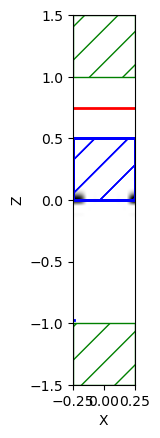

In [6]:
x0 =  np.ones((Nx*Nz,))*0
middle_index = (Nx*Nz) // 2
x0[1] = 0
x0[0] = 1
x0[11] = 0
opt.update_design([x0])

# opt.plot2D(True, output_plane = mp.Volume(size = (1.5, 1.5, 0), center = (0,0,0)))
opt.plot2D(True,)
plt.show()

FloatProgress(value=0.0, description='0% done ')

(11, 61)
10.0


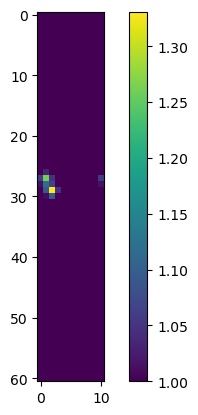

In [74]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1 / 1.55)),until=100)
x=sim.get_epsilon()
print(x.shape)
print(Sx*resolution)
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(11, 61)))));
plt.colorbar()

In [63]:
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  (resolution+1) // 2, (resolution+1) // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(resolution+4, resolution+4)))))
plt.colorbar()

ValueError: cannot reshape array of size 168 into shape (24,24)

ValueError: Axes must be different.

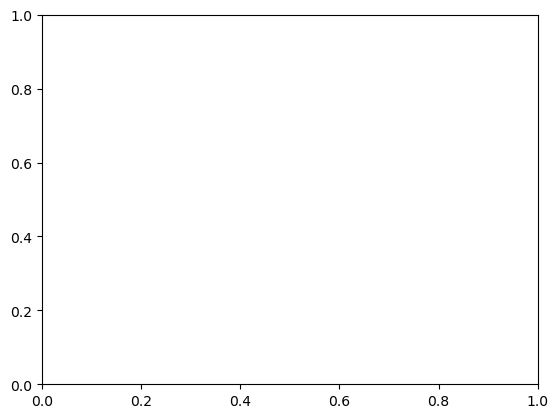

In [64]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[middle_index] = 1
x0[middle_index-1] = 1
x0[0] = 1
x0[1] = 1
opt.update_design([x0])

opt.plot2D(False, output_plane = mp.Volume(size = (1.5, 1.5, 0), center = (0,0,0)))
plt.show()

In [65]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=30)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

FloatProgress(value=0.0, description='0% done ', max=30.0)

ValueError: cannot reshape array of size 671 into shape (220,1220)

In [66]:
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  (resolution+1) // 2, (resolution+1) // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(resolution+4, resolution+4)))))
plt.colorbar()

ValueError: cannot reshape array of size 168 into shape (24,24)

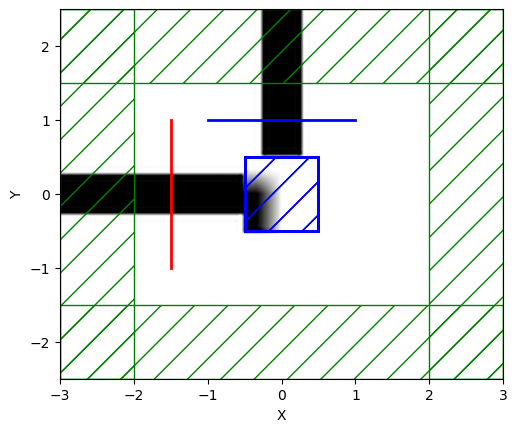

In [12]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[21] = 1
# x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

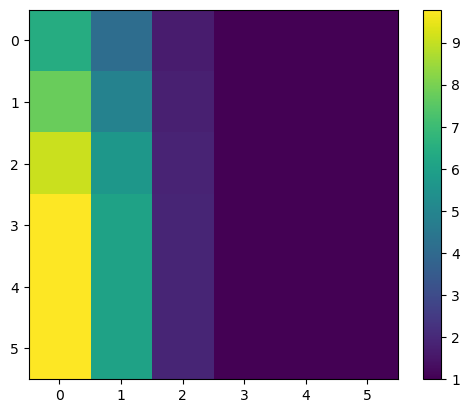

In [13]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

In [14]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
# x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 9

FloatProgress(value=10.0, description='0% done ', max=20.0, min=10.0)

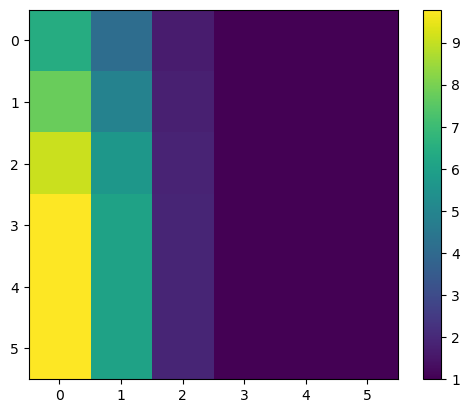

In [15]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

In [16]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 9

FloatProgress(value=20.0, description='0% done ', max=30.0, min=20.0)

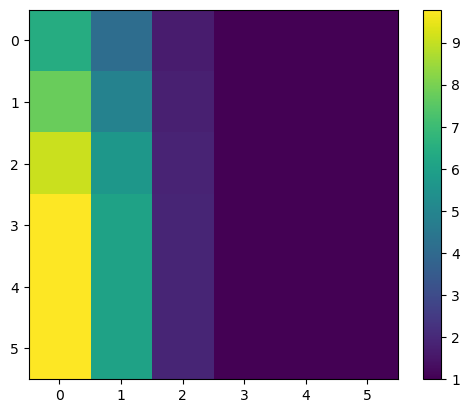

In [17]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

In [18]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1

# x0[42] = 1
# x0[43] = 1


x0[63] = 1
x0[64] = 1

x0[84] = 1
x0[85] = 1

x0[126] = 1
x0[127] = 1

x0[147] = 1
x0[148] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 9

FloatProgress(value=30.0, description='0% done ', max=40.0, min=30.0)

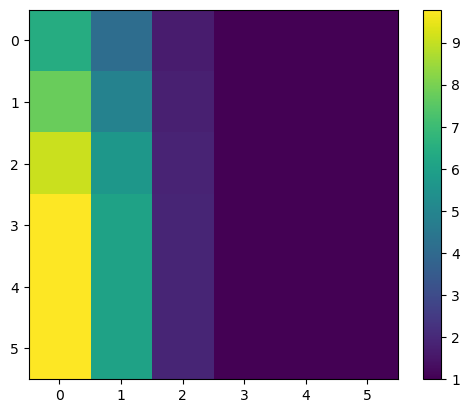

In [19]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

In [20]:
print(cropped_x[2,2])
print(cropped_x[5,2])
print(cropped_x[8,2])

1.9053254437869829
1.0


IndexError: index 8 is out of bounds for axis 0 with size 6

In [21]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1

# x0[42] = 1
# x0[43] = 1

x0[73] = 1
x0[74] = 1

x0[94] = 1
x0[95] = 1


x0[63] = 1
x0[64] = 1

x0[84] = 1
x0[85] = 1

x0[126] = 1
x0[127] = 1

x0[147] = 1
x0[148] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 9

FloatProgress(value=40.0, description='0% done ', max=50.0, min=40.0)

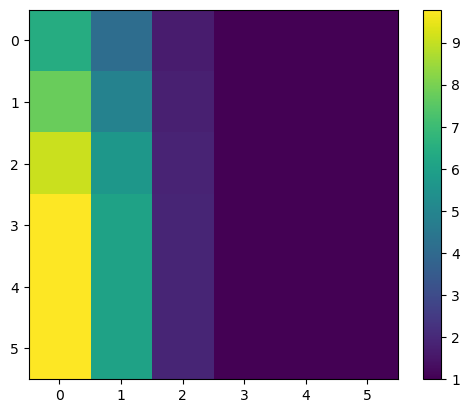

In [22]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

In [23]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1

# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 9

FloatProgress(value=50.0, description='0% done ', max=60.0, min=50.0)

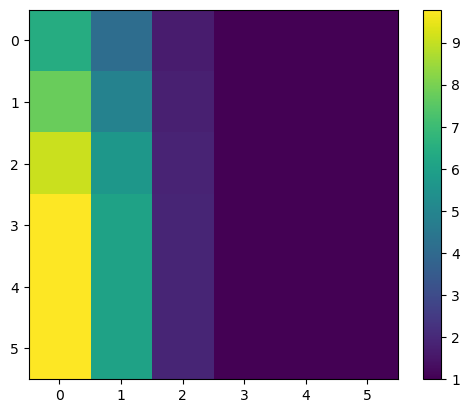

In [24]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))))
plt.colorbar()

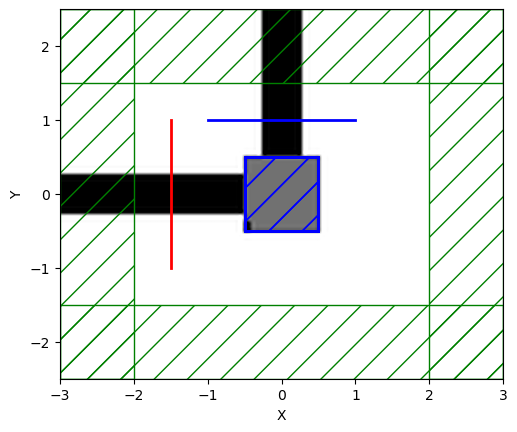

In [254]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

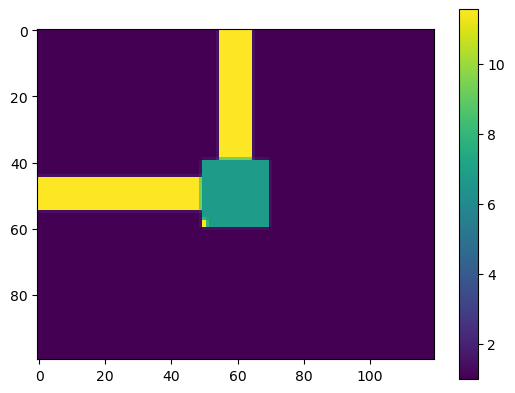

In [255]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

In [ ]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

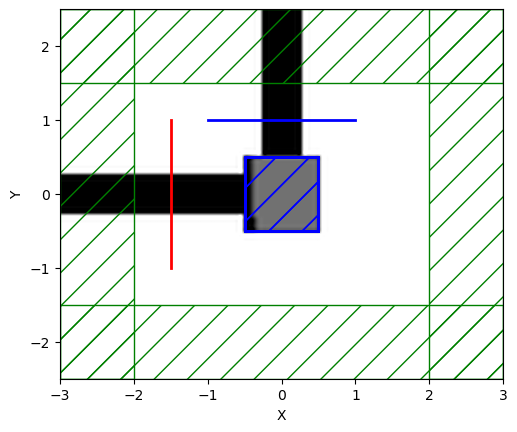

In [211]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0:46] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

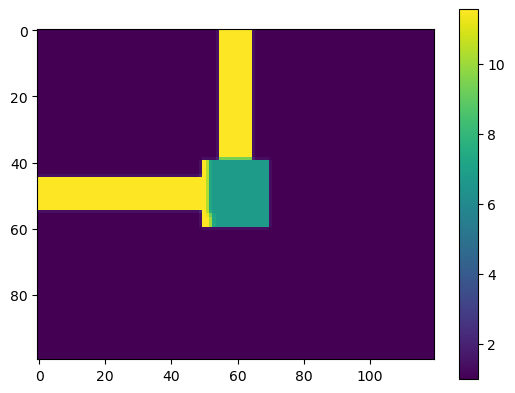

In [212]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

In [202]:
x0 = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0])
opt.update_design([x0])

opt.plot2D(True)
plt.show()

ValueError: weights of shape 1681 do not match user specified grid dimension: Vector3<41.0, 41.0, 1>

In [28]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)

FloatProgress(value=0.0, description='0% done ', max=10.0)

In [29]:
x=sim.get_epsilon()

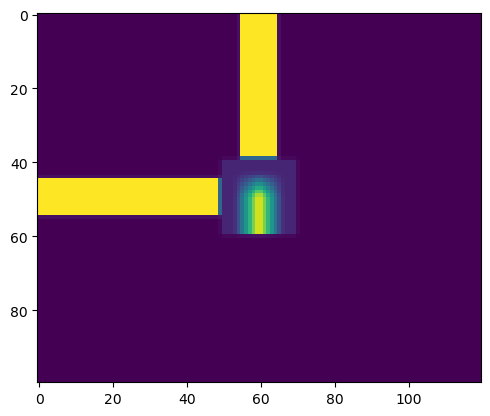

In [30]:
plt.imshow(np.rot90(np.squeeze(x.reshape(Sx*resolution, Sy*resolution))));

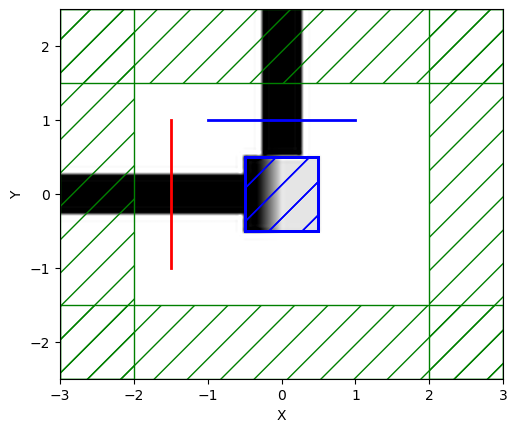

In [44]:
x0 = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0])
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [45]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)

FloatProgress(value=0.0, description='0% done ', max=10.0)

In [46]:
x=sim.get_epsilon()

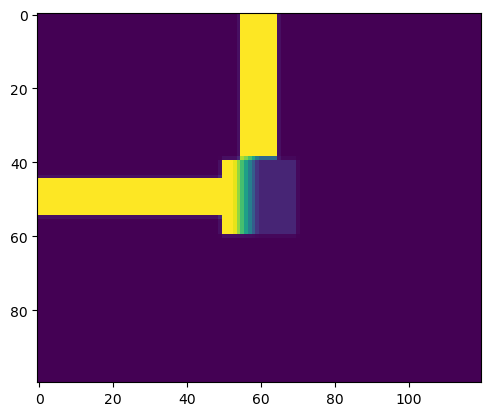

In [47]:
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));